In [1]:
import torch 
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam, SGD
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import LRScheduler, MultiStepLR
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler

from collections import OrderedDict

In [3]:
np.load('label.npy').shape

(101, 256, 5)

In [5]:
a = np.load('WIDE12H_bin2_2arcmin_kappa.npy')

In [6]:
a.shape

(101, 256, 132019)

In [2]:
# import sys
# sys.path.append("/home/orti_ma/dgverification/extension_singular_riemannian_framework_code/cpp.py")

import os
os.chdir("/home/orti_ma/dgverification/extension_singular_riemannian_framework_code/ccpp")
os.chdir("/home/orti_ma/dgverification/extension_singular_riemannian_framework_code/mnist")
#from model import Model
# from simec_algorithm import simec
from algorithms import simec, simec_simexp
from jacobian_function import jacobian
os.chdir("/home/orti_ma/dgverification")

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda', index=1)

In [4]:
df_train = pd.read_csv('data/canonical-paritioned-dataset/shifts_canonical_train.csv')
df_dev_in = pd.read_csv('data/canonical-paritioned-dataset/shifts_canonical_dev_in.csv')
df_dev_out = pd.read_csv('data/canonical-paritioned-dataset/shifts_canonical_dev_out.csv')
df_eval_in = pd.read_csv('data/canonical-paritioned-dataset/shifts_canonical_eval_in.csv')
df_eval_out = pd.read_csv('data/canonical-paritioned-dataset/shifts_canonical_eval_out.csv')

In [5]:
df_train = df_train.dropna()
df_dev_in = df_dev_in.dropna()
df_dev_out = df_dev_out.dropna()
df_eval_in = df_eval_in.dropna()
df_eval_out = df_eval_out.dropna()

In [6]:
classes_weights = (1-(df_train['fact_cwsm_class'].value_counts()/(df_train['fact_cwsm_class'].value_counts().sum()))).values

In [7]:
df_train_balanced = pd.concat([df_train[df_train['fact_cwsm_class']==0][:2000],
 df_train[df_train['fact_cwsm_class']==10][:2000],
 df_train[df_train['fact_cwsm_class']==20][:2000],
 df_train[df_train['fact_cwsm_class']==21][:2000],
 df_train[df_train['fact_cwsm_class']==11][:2000],
 df_train[df_train['fact_cwsm_class']==23][:2000],
 df_train[df_train['fact_cwsm_class']==13][:2000],
 df_train[df_train['fact_cwsm_class']==22],
 df_train[df_train['fact_cwsm_class']==12]], axis=0).sort_index()

<Axes: xlabel='fact_cwsm_class', ylabel='Count'>

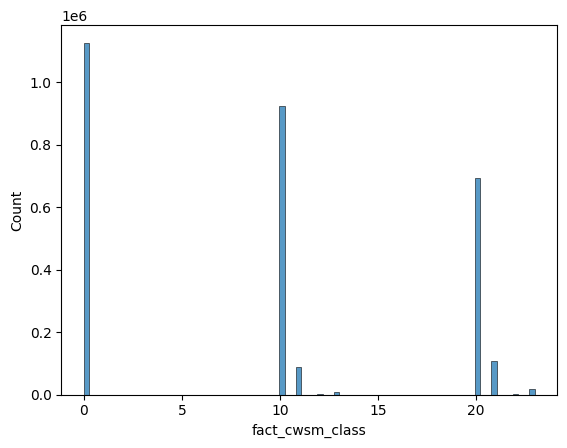

In [8]:
sns.histplot(df_train['fact_cwsm_class'])

<Axes: xlabel='fact_cwsm_class', ylabel='Count'>

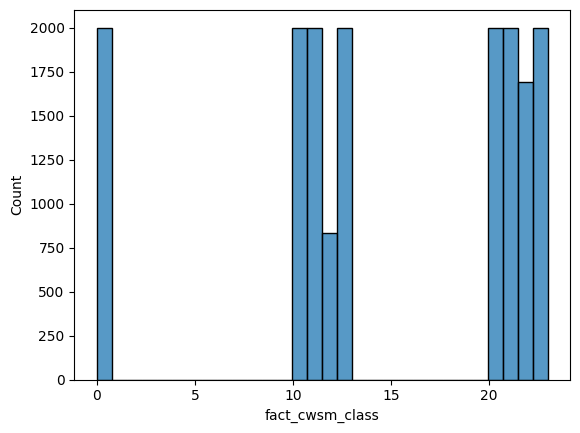

In [9]:
sns.histplot(df_train_balanced['fact_cwsm_class'])

<Axes: xlabel='fact_cwsm_class', ylabel='Count'>

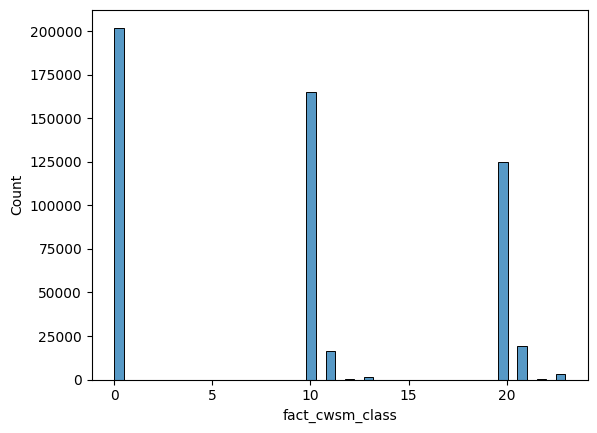

In [10]:
sns.histplot(df_eval_in['fact_cwsm_class'])

In [11]:
#X_train = df_train.iloc[:,6:]
#X_dev_in = df_dev_in.iloc[:,6:]
#y_train = df_train['fact_cwsm_class']
#y_dev_in = df_dev_in['fact_cwsm_class']
##X_dev_out = df_dev_out.iloc[:,6:]
#y_dev_out = df_dev_out['fact_cwsm_class']

In [12]:
id_file = 'Shifts'
global_labels = 9
#id_file = 'CwC_754386'
modelfile = f'models/FFmodel_{id_file}.pth'
train_metricfile = f'.metrics/FFmodel_{id_file}_layers_train_metrics.json'
val_metricfile = f'metrics/FFmodel_{id_file}_layers_val_metrics.json'
softmax_metricfile = f'metrics/FFmodel_{id_file}_softmax_metrics.json'

In [13]:
def save_FF_model(model, PATH):
#This function works for both cases one- and multi-pass.
    final_model_dict = {}
    
    dict_last_layer = model.state_dict()
    final_model_dict.update(dict_last_layer)

    orderded_dict = OrderedDict(final_model_dict)
    torch.save(orderded_dict, PATH)
    
    return orderded_dict

In [14]:
def load_FF_model(model, PATH, one_pass=False):
    
    full_dict = torch.load(PATH, map_location=device)

    if one_pass == False:
        if 'softmax.weight' in list(full_dict.keys()):
            for item in list(full_dict.keys()):
                if item[0:7] == 'softmax':
                    del full_dict[item]
            model.load_state_dict(full_dict)
        else:
            model.load_state_dict(full_dict)
    model.load_state_dict(full_dict)

In [15]:
def loaders(batch_size = 5000):
    featuresTrain = torch.Tensor(df_train_balanced.iloc[:,6:].astype('float').values)
    featuresTest = torch.Tensor(df_dev_in.iloc[:,6:].astype('float').values)
    featuresValid = torch.Tensor(df_eval_in.iloc[:,6:].astype('float').values)
    targetsTrain = torch.Tensor(df_train_balanced['fact_cwsm_class'].values)
    targetsTest = torch.Tensor(df_dev_in['fact_cwsm_class'].values)
    targetsValid = torch.Tensor(df_eval_in['fact_cwsm_class'].values)

    # Pytorch train and test sets
    train_pytorch = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
    test_pytorch =  torch.utils.data.TensorDataset(featuresTest, targetsTest)
    val_pytorch =  torch.utils.data.TensorDataset(featuresValid, targetsValid)

    train_loader = torch.utils.data.DataLoader(train_pytorch, batch_size=batch_size,
                                            shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_pytorch, batch_size=batch_size,
                                            shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_pytorch, batch_size=batch_size,
                                            shuffle=True)
    del train_pytorch, test_pytorch, featuresTest, targetsTest, featuresTrain, targetsTrain

    return train_loader, val_loader, test_loader

In [16]:
def one_hot_encoding_ids(X):
    # ids = pd.Series(data=['0', '1', '2', '3', '4', '5', '6', '7', '8'])
    ids = pd.Series(data=['0', '10', '11', '12', '13', '20', '21', '22', '23'])
    X1 = X
    difference = list( set(ids).difference( set( X1.unique() ) ) )
    if difference != []:
        extension = pd.concat( [X1, pd.Series( difference ) ] , axis=0)
        X2 = pd.get_dummies(extension, columns=ids, dtype='int')
        X3 = X2.iloc[:len(X1)]
        return X3
    else:
        X2 = pd.get_dummies(X1, columns=ids, dtype='int')
        return X2

#  Building FF model #

In [17]:
def should_detach(olu, index, iteration):
    return (index % 2 == 0) ^ (iteration % 2 == 0) if olu else True

In [18]:
class Triangle(nn.Module):
    __constants__ = ["inplace"]
    inplace: bool

    def __init__(self, inplace: bool = False):
        super().__init__()
        self.inplace = inplace

    def forward(self, input):
        input = input.mean(dim=1).reshape((input.size(0),1,input.size(2),input.size(3)))-input
        return F.relu(input, inplace=self.inplace)

    def extra_repr(self) -> str:
        inplace_str = "inplace=True" if self.inplace else ""
        return inplace_str

In [29]:
class Net(torch.nn.Module):

    def __init__(self, list_act_layers):
        super(Net, self).__init__()
        # Give the number of convolutional layers without flatten
        self.size_image1d = 32
        #self.embedding = nn.Embedding(10, self.size_image1d*self.size_image1d)
        l0 = Linear_Layer(123,90, prev=None, relu=True, index=0).to(device)
        l1 = Linear_Layer(90,90, prev=l0, relu=True, index=1).to(device)
        l2 = Linear_Layer(90,90, prev=l1, relu=True, index=2).to(device)
        l3 = Linear_Layer(90,90, prev=l2, relu=True, index=3).to(device)

        # l0 = Linear_Layer(123,9*11, prev=None, relu=True, index=0).to(device)
        # l1 = Linear_Layer(9*11,9*14, prev=l0, relu=True, index=1).to(device)
        # l2 = Linear_Layer(9*14,9*14, prev=l1, relu=True, index=2).to(device)
        # l3 = Linear_Layer(9*14,9*14, prev=l2, relu=True, index=3).to(device)
        self.list_act_layers = list_act_layers
        self.layers = nn.ModuleList([l0, l1, l2, l3]).to(device)
        self.num_epoch = 70
        self.olu = True

    def init_one_pass(self):
        #########These values are calculated by hand given the structure of the CNN
        print('Calculations of the input dimension in the softmax layer is currently only implemented for CNN layers')
        sum_dim = 0
        w = self.size_image1d
        for j in range(len(self.layers)):
            k = self.layers[j].inner[1].kernel_size[0]
            p = self.layers[j].inner[1].padding[0]
            s = self.layers[j].inner[1].stride[0]
            cnn_output = np.floor((w-k+2*p)/s) + 1
            if type(self.layers[j].inner[3]) != type(nn.Identity()):
                #This operation depends on the properties of the maxpool layer
                cnn_output = cnn_output/2
            if j in self.list_act_layers:
                sum_dim += self.layers[j].inner[1].out_channels*cnn_output*cnn_output
            w = cnn_output
        print(f'sum_dim = {sum_dim}')
        #sum_dim = 7750    
        self.softmax = Softmax_Layer(int(sum_dim),global_labels).to(device)

    def evaluate_one_pass(self, data_loader, criterion, optimizer, validation=False):
        running_loss = 0
        for batch_x_neutral, batch_labels in data_loader:
            batch_x_neutral = batch_x_neutral.to(device)
            batch_labels = batch_labels.to(device)
            outputs = self.forward(batch_x_neutral)
            loss = criterion(outputs, batch_labels)
            if validation == False:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * batch_x_neutral.size(0)
        epoch_loss = running_loss / len(data_loader.dataset)
        return epoch_loss

    def train_one_pass(self, data_loader, epoch, learning_rate, val_loader = None):
        print('Training softmax layer')
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(self.softmax.parameters(), lr=learning_rate)
        metrics = { 'epoch_loss': [] , 'val_loss': []}
        for i in range(epoch):
            epoch_loss = self.evaluate_one_pass(data_loader, criterion, optimizer, validation=False)
            metrics['epoch_loss'].append(epoch_loss)
            print(f'Loss:{epoch_loss}')

            if val_loader != None:
                val_loss = self.evaluate_one_pass(val_loader, criterion, optimizer, validation=True)
                metrics['val_loss'].append(val_loss) 
                print(f'Validation loss layer:{val_loss}') 

        json_metrics = json.dumps(metrics)
        with open(softmax_metricfile, 'w') as outfile:
            outfile.write(json_metrics)
    
    def evaluate_multi_pass(self, h_loader, validation=False,):
        running_train_losses = [ 0.0 for item in range(len(self.layers)) ]
        running_val_accuracy = [ 0.0 for item in range(len(self.layers)) ] 
        for j, (batch_x, batch_y) in enumerate(h_loader):
            batch_x_val = batch_x.to(device)
            batch_y_val = batch_y.to(device)
            for id, layer in enumerate(self.layers):
                if validation == False:
                    layer.train(True)
                    batch_x, batch_y, loss = layer.train_l(batch_x, batch_y, iteration=j, validation=validation, olu=self.olu)
                else:
                    layer.eval()
                    with torch.no_grad():
                        batch_x, batch_y, loss = layer.train_l(batch_x, batch_y, iteration=j, validation=validation, olu=self.olu)
                        prediction_layer = self.predict_multi_pass_layer(batch_x_val, id)
                        # print(prediction_layer)
                        accuracy_layer = accuracy_score(y_true=batch_y_val.cpu(), y_pred=prediction_layer.cpu())
                        running_val_accuracy[id] += (accuracy_layer * batch_x_val.size(0))
                running_train_losses[id] += loss
        for layer in self.layers:
            layer.scheduler.step() if validation == False else None
            #print(f'lr {layer.scheduler.get_last_lr()}')
        epoch_losses = [ item / len(h_loader.dataset) for item in running_train_losses ]
        epoch_accuracies = [ item / len(h_loader.dataset) for item in running_val_accuracy ]
        if validation == True:
            return epoch_losses, epoch_accuracies
        else:
            return epoch_losses
    
    def train_multi_pass(self, data_loader, val_loader=None):
        train_metrics = { f'epoch_loss_{id}': [] for id in range(len(self.layers))} 
        val_loss = { f'val_loss_{id}': [] for id in range(len(self.layers))} 
        val_acc = { f'val_acc_{id}': [] for id in range(len(self.layers))} 
        h_loader = data_loader
        v_loader = val_loader
        for i in tqdm(range(self.num_epoch)):
            epoch_losses = self.evaluate_multi_pass(h_loader)
            print(f'Loss: {epoch_losses}')
            val_losses, val_accuracies = self.evaluate_multi_pass(v_loader, validation=True)
            #print(val_losses)
            # if i%1 == 0:
            print(f'Accuracy: {val_accuracies}')
            for id in range(len(self.layers)):
                train_metrics[f'epoch_loss_{id}'].append(epoch_losses[id])
                if val_loader != None:
                    val_loss[f'val_loss_{id}'].append(val_losses[id])
                    val_acc[f'val_acc_{id}'].append(val_accuracies[id])
        val_metrics = val_loss | val_acc
        json_train_metrics = json.dumps(train_metrics)
        with open(train_metricfile, 'w') as outfile:
            outfile.write(json_train_metrics)
        json_val_metrics = json.dumps(val_metrics)
        with open(val_metricfile, 'w') as outfile:
            outfile.write(json_val_metrics)

    def predict_multi_pass_layer(self, x, id):
        goodness_per_label = torch.zeros(x.shape[0],global_labels).to(device)
        x_ = x
        for i, layer in enumerate(self.layers):
            x_ = layer(x_)
            if i == id:
                s = x_.shape[1]/global_labels
                # h = x_.shape[2]
                # w = x_.shape[3]
                y_i_channels = torch.split(x_, int(s), dim=1)
                for j, item in enumerate(y_i_channels):
                    G_ni = (torch.sum(item**2, dim=[1]))/(s)
                    goodness_per_label[:,j] += G_ni
        return goodness_per_label.argmax(1)
    
    def predict_multi_pass(self, x):
        goodness_per_label = torch.zeros(x.shape[0],global_labels).to(device)
        x_ = x
        for i, layer in enumerate(self.layers):
            x_ = layer(x_)
            if i in list(set(range(len(self.layers)))-set(self.list_act_layers)):
                continue
            s = x_.shape[1]/global_labels
            # h = x_.shape[2]
            # w = x_.shape[3]
            y_i_channels = torch.split(x_, int(s), dim=1)
            for j, item in enumerate(y_i_channels):
                G_ni = (torch.sum(item**2, dim=[1]))/(s)
                goodness_per_label[:,j] += G_ni
        return goodness_per_label.argmax(1)
    
    def forward(self, x):
        activations = []
        x_ = x
        for i, layer in enumerate(self.layers):
            layer.eval()
            with torch.no_grad():
                x_ = layer(x_)
                if i in list(set(range(len(self.layers)))-set(self.list_act_layers)):
                    continue
                flatten = torch.nn.Flatten()
                activations.append(flatten(x_))
        activations_cat = torch.cat(activations, dim=1)
        return self.softmax(activations_cat)

In [20]:
class Convolutional_Layer(nn.Module):

    def __init__(self, in_channels, 
                 out_channels, kernel_size, stride=1, last = False, maxpool=False, 
                 relu = True, regularization=0.1, lr=0.001,
                 threshold=4.0, prev=None, index=None, ):
        super().__init__()

        self.device = device
        self.inner = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, bias=False, stride=stride),
            nn.ReLU(inplace=True) if relu else Triangle(),
            nn.MaxPool2d(2) if maxpool else nn.Identity(),
            nn.Flatten() if last else nn.Identity(),
        )
        params = list(prev.parameters()) if prev else list()
        self.opt = Adam(params + list(self.inner.parameters()), lr=lr) #, weight_decay=0.0001)
        self.scheduler = MultiStepLR(self.opt, milestones=[35, 45, 55, 60], gamma=0.2)
        self.threshold = threshold
        self.index = index
        self.last = last
        self.regularization = regularization

    def forward(self, x):
        out = self.inner(x)
        return out
    
    def train_l(self, batch_x, batch_y, iteration, validation=False, olu=True):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        if should_detach(olu, self.index, iteration):
            output = self.forward(batch_x)
            s = output.shape[1]/global_labels
            h = output.shape[2]
            w = output.shape[3]
            G_nj = torch.Tensor().to(device)
            y_i_channels = torch.split(output, int(s), dim=1)
            # for item in y_i_channels:
            #     G_ni = (torch.sum(item**2, dim=[1,2,3]))/(s*h*w)
            #     G_nj = torch.cat((G_ni.reshape(G_ni.shape[0],1), G_nj), dim = 1)
            goodness_factors = [item.pow(2).mean((1, 2, 3)).unsqueeze(-1) for item in y_i_channels]
            G_nj = torch.cat(goodness_factors, 1)
            z_binary_mask = torch.tensor(one_hot_encoding_ids(pd.Series(data=batch_y.int().cpu(), dtype='str')).values).float().to(device)
            g_pos = torch.matmul(G_nj, torch.transpose(z_binary_mask,0, 1)).diag()
            #g_neg = torch.matmul(G_nj, torch.transpose((1-z_binary_mask),0, 1)).diag()
            #loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
            #loss = F.softplus((-g_pos + (1/9)*g_neg)*self.threshold).mean()
            loss = -(torch.log ( (torch.exp(g_pos)+1e-9)/(torch.sum(torch.exp(G_nj), dim=1)+1e-9) )).mean()
            #loss = (torch.nn.functional.relu(self.threshold + g_neg - g_pos) + self.regularization*g_neg).mean()
            if validation == False:
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
            running_loss = loss.item() * batch_x.size(0)
            return self.forward(batch_x).detach(), batch_y, running_loss
        else:
            return self.forward(batch_x), batch_y, 0

In [21]:
class Linear_Layer(nn.Module):

    def __init__(self, in_features, 
                 out_features, 
                 relu = True, regularization=0.1, lr=0.001,
                 threshold=4.0, prev=None, index=None ):
        super().__init__()

        self.device = device
        self.inner = nn.Sequential(
            #nn.BatchNorm1d(in_features),
            nn.Linear(in_features, out_features),
            nn.ReLU(inplace=True) if relu else Triangle(),
        )
        params = list(prev.parameters()) if prev else list()
        self.opt = Adam(params + list(self.inner.parameters()), lr=lr) #, weight_decay=0.0001)
        self.scheduler = MultiStepLR(self.opt, milestones=[35, 45, 55, 60], gamma=0.2)
        self.threshold = threshold
        self.index = index
        self.regularization = regularization

    def forward(self, x):
        x_direction = x / (x.norm(2,1, keepdim=True) + 1e-2)
        out = self.inner(x_direction)
        return out
    
    def train_l(self, batch_x, batch_y, iteration, validation=False, olu=True):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        if should_detach(olu, self.index, iteration):
            output = self.forward(batch_x)
            s = output.shape[1]/global_labels
            G_nj = torch.Tensor().to(device)
            y_i_channels = torch.split(output, int(s), dim=1)
            # for item in y_i_channels:
            #     G_ni = (torch.sum(item**2, dim=[1,2,3]))/(s*h*w)
            #     G_nj = torch.cat((G_ni.reshape(G_ni.shape[0],1), G_nj), dim = 1)
            goodness_factors = [item.pow(2).mean(1).unsqueeze(-1) for item in y_i_channels]
            G_nj = torch.cat(goodness_factors, 1)
           # print(G_nj)
            classes_weights_normalized = classes_weights #/classes_weights.mean()
            z_binary_mask = one_hot_encoding_ids(pd.Series(data=batch_y.int().cpu(), dtype='str')).values
            weight_g_pos = (torch.Tensor(z_binary_mask*classes_weights_normalized).sum(1)).to(device)
            weight_g_neg = (torch.Tensor((1-z_binary_mask)*classes_weights_normalized)).to(device)
            inverse_z_binary_mask = torch.tensor((1-z_binary_mask)).float().to(device)
            z_binary_mask = torch.tensor(z_binary_mask).float().to(device)
            g_pos = weight_g_pos*torch.matmul(G_nj, torch.transpose(z_binary_mask,0, 1)).diag()
            g_neg = (torch.matmul(torch.multiply(weight_g_neg,G_nj), torch.transpose(inverse_z_binary_mask,0, 1)).diag())*(1/(global_labels-1))
            lambda_ = +0.0
            regularized_g_neg = (lambda_*(g_neg)).reshape(g_neg.shape[0],1)
            regularization_matrix = z_binary_mask*regularized_g_neg - inverse_z_binary_mask*regularized_g_neg
            G_nj_regularized = (G_nj + regularization_matrix)*torch.Tensor(classes_weights_normalized).to(device)
            # loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
            # loss = (torch.nn.functional.relu(self.threshold + g_neg - g_pos) + self.regularization*g_neg).mean()
            loss = F.softplus(-(g_pos) + ((g_neg))) .mean()
            #loss = -(torch.log ( ((torch.exp(g_pos)+1e-9)/(torch.sum(torch.exp(G_nj), dim=1)+1e-9))) ).mean()
            loss = -(torch.log ( (torch.exp(g_pos+regularized_g_neg.reshape(g_neg.shape[0],))+1e-9)/(torch.sum(torch.exp(G_nj_regularized), dim=1)+1e-9) ) 
                    + torch.log ( (torch.exp(g_neg-regularized_g_neg.reshape(g_neg.shape[0],))+1e-9)/(torch.sum(torch.exp(G_nj_regularized), dim=1)+1e-9) ) ).mean() 
                    #+ self.regularization*(torch.exp(g_neg)/torch.exp(g_pos)).mean()
            # print(torch.exp(G_nj).isnan().sum())
            if validation == False:
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
            running_loss = loss.item() * batch_x.size(0)
            return self.forward(batch_x).detach(), batch_y, running_loss
        else:
            return self.forward(batch_x), batch_y, 0

In [22]:
class Linear_Layer(nn.Module):

    def __init__(self, in_features, 
                 out_features, 
                 relu = True, regularization=0.1, lr=0.001,
                 threshold=4.0, prev=None, index=None ):
        super().__init__()

        self.device = device
        self.inner = nn.Sequential(
            #nn.BatchNorm1d(in_features),
            nn.Linear(in_features, out_features),
            nn.ReLU(inplace=True) if relu else Triangle(),
        )
        params = list(prev.parameters()) if prev else list()
        self.opt = Adam(params + list(self.inner.parameters()), lr=lr) #, weight_decay=0.0001)
        self.scheduler = MultiStepLR(self.opt, milestones=[35, 45, 55, 60], gamma=0.2)
        self.threshold = threshold
        self.index = index
        self.regularization = regularization

    def forward(self, x):
        x_direction = x / (x.norm(2,1, keepdim=True) + 1e-2)
        out = self.inner(x_direction)
        return out
    
    def train_l(self, batch_x, batch_y, iteration, validation=False, olu=True):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        if should_detach(olu, self.index, iteration):
            output = self.forward(batch_x)
            s = output.shape[1]/global_labels
            G_nj = torch.Tensor().to(device)
            y_i_channels = torch.split(output, int(s), dim=1)
            # for item in y_i_channels:
            #     G_ni = (torch.sum(item**2, dim=[1,2,3]))/(s*h*w)
            #     G_nj = torch.cat((G_ni.reshape(G_ni.shape[0],1), G_nj), dim = 1)
            goodness_factors = [item.pow(2).mean(1).unsqueeze(-1) for item in y_i_channels]
            G_nj = torch.cat(goodness_factors, 1)
           # print(G_nj)
            classes_weights_normalized = classes_weights /classes_weights.mean()
            #print(classes_weights_normalized)
            z_binary_mask = one_hot_encoding_ids(pd.Series(data=batch_y.int().cpu(), dtype='str')).values
            weight_g_pos = (torch.Tensor(z_binary_mask*classes_weights_normalized).sum(1)).to(device)
            weight_g_neg = (torch.Tensor((1-z_binary_mask)*classes_weights_normalized)).to(device)
            inverse_z_binary_mask = torch.tensor((1-z_binary_mask)).float().to(device)
            z_binary_mask = torch.tensor(z_binary_mask).float().to(device)
            # g_pos = weight_g_pos*torch.matmul(G_nj, torch.transpose(z_binary_mask,0, 1)).diag()
            g_pos = torch.matmul(G_nj, torch.transpose(z_binary_mask,0, 1)).diag()
            # g_neg = (torch.matmul(torch.multiply(weight_g_neg,G_nj), torch.transpose(inverse_z_binary_mask,0, 1)).diag())*(1/(global_labels-1))
            g_neg = (torch.matmul(G_nj, torch.transpose(inverse_z_binary_mask,0, 1)).diag())*(1/(global_labels-1))
            lambda_ = +0.0
            regularized_g_neg = (lambda_*(g_neg)).reshape(g_neg.shape[0],1)
            regularization_matrix = z_binary_mask*regularized_g_neg - inverse_z_binary_mask*regularized_g_neg
            # G_nj_regularized = (G_nj + regularization_matrix)*torch.Tensor(classes_weights_normalized).to(device)
            G_nj_regularized = (G_nj + regularization_matrix).to(device)
            # loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
            # loss = (torch.nn.functional.relu(self.threshold + g_neg - g_pos) + self.regularization*g_neg).mean()
            # loss = F.softplus(-(g_pos) + ((g_neg))).mean()
            #loss = -(torch.log ( ((torch.exp(g_pos)+1e-9)/(torch.sum(torch.exp(G_nj), dim=1)+1e-9))) ).mean()
            loss = -(torch.log ( (torch.exp(g_pos+regularized_g_neg.reshape(g_neg.shape[0],))+1e-9)/(torch.sum(torch.exp(G_nj_regularized), dim=1)+1e-9) ) 
                    + torch.log ( (torch.exp(g_neg-regularized_g_neg.reshape(g_neg.shape[0],))+1e-9)/(torch.sum(torch.exp(G_nj_regularized), dim=1)+1e-9) ) ).mean() 
                    #+ self.regularization*(torch.exp(g_neg)/torch.exp(g_pos)).mean()
            # print(torch.exp(G_nj).isnan().sum())

            if validation == False:
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
            running_loss = loss.item() * batch_x.size(0)
            return self.forward(batch_x).detach(), batch_y, running_loss
        else:
            return self.forward(batch_x), batch_y, 0

In [23]:
class Softmax_Layer(nn.Linear):

    def __init__(self, in_features, out_features,
                 bias=True, device = None, dtype = None):
        super(Softmax_Layer, self).__init__(in_features, out_features, bias, device, dtype)
        self.flatten = torch.nn.Flatten()
        self.batch1d = torch.nn.BatchNorm1d(in_features)
        #self.softmax = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        #x_direction = x / (x.norm(2,1, keepdim=True) + 1e-4)
        x_direction = self.flatten(x)
        x_direction = self.batch1d(x)
        #return F.linear(x_direction, self.weight, self.bias)
        return self.softmax(F.linear(x_direction, self.weight, self.bias))

In [24]:
if __name__ == '__main__':
    train_loader, val_loader, test_loader = loaders()

In [25]:
x, y = next(iter(train_loader))

In [30]:
model = Net([2,3])   
model.to(device)
model.train_multi_pass(train_loader, val_loader)

  0%|          | 0/70 [00:00<?, ?it/s]

Loss: [1.735026586145213, 2.6593559505690734, 1.7349788009673104, 2.659349746260854]


  1%|▏         | 1/70 [00:11<13:19, 11.58s/it]

Accuracy: [0.3798070412999323, 0.0, 3.7613781689611072e-06, 0.0]
Loss: [1.735015131203091, 2.659306748962033, 1.734914333991755, 2.65927616027965]


  3%|▎         | 2/70 [00:22<12:58, 11.45s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7350017189315836, 2.6592361929918193, 1.734868004027131, 2.6591960814177513]


  4%|▍         | 3/70 [00:35<13:28, 12.07s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.734991030322527, 2.6591688113188345, 1.7348393962216475, 2.6591274011686274]


  6%|▌         | 4/70 [00:48<13:21, 12.15s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7349793386355465, 2.659122062577834, 1.7347707120479379, 2.659077766702874]


  7%|▋         | 5/70 [01:00<13:19, 12.30s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7349683689568989, 2.6590266893747443, 1.7347338187495434, 2.6589813834961205]


  9%|▊         | 6/70 [01:13<13:13, 12.40s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7349437556870477, 2.6589668105861173, 1.7346877205663316, 2.65888788601412]


 10%|█         | 7/70 [01:25<12:53, 12.27s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7349495928156493, 2.6588609044876783, 1.7346809249153958, 2.6588104043044987]


 11%|█▏        | 8/70 [01:37<12:38, 12.23s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7349253584991728, 2.6588127128843015, 1.7346009134640274, 2.6587218125545786]


 13%|█▎        | 9/70 [01:49<12:29, 12.28s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.734926279276227, 2.658734221171017, 1.7345329788861799, 2.6586020549773246]


 14%|█▍        | 10/70 [02:02<12:19, 12.33s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7348996586962377, 2.658697283894177, 1.734439214070638, 2.65855804767484]


 16%|█▌        | 11/70 [02:14<12:02, 12.24s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7348849285719499, 2.6585615105445437, 1.7344567782074913, 2.658447524416796]


 17%|█▋        | 12/70 [02:26<11:49, 12.24s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7348666744005936, 2.6585302004309725, 1.7343510496388392, 2.6583593655255884]


 19%|█▊        | 13/70 [02:38<11:33, 12.16s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7348743047185569, 2.6583414740321194, 1.7344498763618847, 2.6581296618352415]


 20%|██        | 14/70 [02:50<11:22, 12.19s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7348452393525566, 2.65827683379765, 1.7343479178194792, 2.6581475533287104]


 21%|██▏       | 15/70 [03:02<11:12, 12.22s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7348121137718286, 2.6582569222968533, 1.7342353371551151, 2.658115666070189]


 23%|██▎       | 16/70 [03:15<10:58, 12.19s/it]

Accuracy: [0.3798070412999323, 0.0, 0.0, 0.0]
Loss: [1.7348266554005756, 2.6580426572339353, 1.734241288096701, 2.657757836200804]


 24%|██▍       | 17/70 [03:27<10:49, 12.26s/it]

Accuracy: [0.3609230422026631, 0.0, 1.3164823591363876e-05, 0.0]
Loss: [1.734783406235698, 2.658078295934636, 1.7340259501213198, 2.6578843752312276]


 26%|██▌       | 18/70 [03:39<10:39, 12.29s/it]

Accuracy: [0.26390205371248027, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7347779661828224, 2.657885818093604, 1.7340801377990176, 2.657583682711954]


 27%|██▋       | 19/70 [03:52<10:34, 12.44s/it]

Accuracy: [0.017437749191303694, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7347850717605964, 2.6577621647879335, 1.7340324687426791, 2.6574639251347]


 29%|██▊       | 20/70 [04:04<10:16, 12.32s/it]

Accuracy: [0.00014857443767396375, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7347591954667354, 2.6576110970971083, 1.7340256094903699, 2.657188915565729]


 30%|███       | 21/70 [04:17<10:15, 12.56s/it]

Accuracy: [5.642067253441661e-06, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7347361544551587, 2.6576118185282964, 1.7338105516611477, 2.6572535558001986]


 31%|███▏      | 22/70 [04:29<09:54, 12.38s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.734704055615298, 2.6575393868369934, 1.7337777211169185, 2.6572975631026834]


 33%|███▎      | 23/70 [04:42<09:43, 12.42s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7347035347996944, 2.6572493714993066, 1.7339574731426475, 2.656993551999944]


 34%|███▍      | 24/70 [04:54<09:27, 12.34s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.734669820415688, 2.657237107169106, 1.73373466864304, 2.656954883288252]


 36%|███▌      | 25/70 [05:06<09:15, 12.35s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7346807643536706, 2.6570225535337126, 1.7337445625234995, 2.656760818298606]


 37%|███▋      | 26/70 [05:18<08:59, 12.27s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7346469913317373, 2.656982153387169, 1.73365332121654, 2.6567856355314823]


 39%|███▊      | 27/70 [05:31<08:45, 12.23s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7346380765199718, 2.6568140599203005, 1.7336718355648397, 2.656600949147284]


 40%|████      | 28/70 [05:43<08:33, 12.24s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7346193546303477, 2.6566896851834416, 1.733712144868768, 2.6564796044214156]


 41%|████▏     | 29/70 [05:54<08:14, 12.05s/it]

Accuracy: [0.0, 0.0, 0.0, 0.0]
Loss: [1.7345984574814046, 2.65654640894945, 1.733567714229446, 2.6563529211047543]


 43%|████▎     | 30/70 [06:06<07:57, 11.94s/it]

Accuracy: [0.0, 0.0, 0.0, 0.0]
Loss: [1.7345790761459599, 2.656522168861524, 1.7334173656612295, 2.6563931769650604]


 44%|████▍     | 31/70 [06:17<07:39, 11.77s/it]

Accuracy: [0.0, 0.0, 0.0, 0.0]
Loss: [1.7345628424436468, 2.6564168399080357, 1.7335604507448137, 2.6562692350869144]


 46%|████▌     | 32/70 [06:29<07:23, 11.67s/it]

Accuracy: [0.0, 0.0, 0.0, 0.0]
Loss: [1.7344955847413972, 2.656432134249227, 1.7332147762406624, 2.656465608656363]


 47%|████▋     | 33/70 [06:41<07:11, 11.65s/it]

Accuracy: [0.0, 0.0, 0.0, 0.0]
Loss: [1.734507624562212, 2.656254662176911, 1.7332859772280729, 2.656236337824729]


 49%|████▊     | 34/70 [06:52<06:56, 11.56s/it]

Accuracy: [0.0, 0.0, 0.0, 0.0]
Loss: [1.734488853038122, 2.656054537165283, 1.7334334704293606, 2.65617227473521]


 50%|█████     | 35/70 [07:03<06:44, 11.55s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344046599407283, 2.656218734903735, 1.7330735365203436, 2.6564532000399246]


 51%|█████▏    | 36/70 [07:15<06:34, 11.61s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344974265263635, 2.6558372420913745, 1.7334526381057447, 2.6558594621719736]


 53%|█████▎    | 37/70 [07:27<06:21, 11.55s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.734465185939703, 2.6558676864875195, 1.733461060728296, 2.6559787868905143]


 54%|█████▍    | 38/70 [07:38<06:08, 11.51s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.734433020035599, 2.655981672615267, 1.7332264224486211, 2.656261010771368]


 56%|█████▌    | 39/70 [07:50<05:59, 11.60s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.734402851745598, 2.6561259588529227, 1.7330750201291536, 2.6564350199739803]


 57%|█████▋    | 40/70 [08:01<05:46, 11.54s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7345002938979073, 2.655718061659071, 1.7334256840514028, 2.65570767304996]


 59%|█████▊    | 41/70 [08:13<05:32, 11.48s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344691577358242, 2.6557238331085773, 1.7333199081568647, 2.6558196391703803]


 60%|██████    | 42/70 [08:24<05:23, 11.55s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344168807541998, 2.655837819236325, 1.7332515953182164, 2.65627255367038]


 61%|██████▏   | 43/70 [08:36<05:13, 11.62s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.734436036195111, 2.655905345195548, 1.7332942450603483, 2.655994514090419]


 63%|██████▎   | 44/70 [08:48<05:01, 11.61s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7343919428980283, 2.655920783822977, 1.7332090523479002, 2.656271832239192]


 64%|██████▍   | 45/70 [08:59<04:49, 11.56s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.734380202615443, 2.6560943601668763, 1.7330232465333553, 2.6562732751015687]


 66%|██████▌   | 46/70 [09:11<04:37, 11.55s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344079216177024, 2.655926266700008, 1.7333059973475489, 2.656131730302429]


 67%|██████▋   | 47/70 [09:22<04:24, 11.50s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7343942107313974, 2.6558782193828687, 1.7333616454328298, 2.6560870015687557]


 69%|██████▊   | 48/70 [09:33<04:13, 11.51s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344017367015534, 2.655926266700008, 1.733174482404219, 2.6561187445410397]


 70%|███████   | 49/70 [09:45<04:01, 11.51s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344154118048716, 2.655919918105551, 1.7331492279263276, 2.6561838176342225]


 71%|███████▏  | 50/70 [09:56<03:49, 11.47s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344028976863362, 2.6558130020034483, 1.7331795720146805, 2.6561138388089596]


 73%|███████▎  | 51/70 [10:08<03:39, 11.55s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7343697544449728, 2.6558682636324704, 1.7331348321998243, 2.6562468707200777]


 74%|███████▍  | 52/70 [10:19<03:25, 11.44s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7343316265181, 2.656216714896408, 1.7327542815188812, 2.656601670578472]


 76%|███████▌  | 53/70 [10:31<03:13, 11.40s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7344807022508424, 2.6557042101802564, 1.733160341660355, 2.655727007405806]


 77%|███████▋  | 54/70 [10:42<03:03, 11.45s/it]

Accuracy: [0.0, 0.0, 0.3798070412999323, 0.0]
Loss: [1.7343656928450972, 2.6558798065314826, 1.7329234144238057, 2.656389858381594]


 77%|███████▋  | 54/70 [10:44<03:10, 11.94s/it]


KeyboardInterrupt: 

In [ ]:
epochs = 100 #20
learning_rate = 0.0001 #0.01
for layer in model23.layers:
    layer.eval()
model23.init_one_pass()
model23.train_one_pass(train_loader, epochs, learning_rate, val_loader=val_loader)

NameError: name 'model23' is not defined

In [ ]:
id_file = 'softmax'
#id_file = 'CwC_164706'
modelfile = f'../admire/models/FFmodel_CNN_2I_CIFAR10_{id_file}.pth'
train_metricfile = f'../admire/metrics/CNN_CIFAR10_layers_train_metrics_{id_file}.json'
val_metricfile = f'../admire/metrics/CNN_CIFAR10_layers_val_metrics_{id_file}.json'
softmax_metricfile = f'../admire/metrics/CNN_CIFAR10_softmax_metrics_{id_file}.json'

In [ ]:
save_FF_model(model23, f'../admire/models/FFmodel_CNN_2I_CIFAR10_{id_file}_[2,3].pth').keys()

odict_keys(['layers.0.inner.0.weight', 'layers.0.inner.0.bias', 'layers.0.inner.0.running_mean', 'layers.0.inner.0.running_var', 'layers.0.inner.0.num_batches_tracked', 'layers.0.inner.1.weight', 'layers.1.inner.0.weight', 'layers.1.inner.0.bias', 'layers.1.inner.0.running_mean', 'layers.1.inner.0.running_var', 'layers.1.inner.0.num_batches_tracked', 'layers.1.inner.1.weight', 'layers.2.inner.0.weight', 'layers.2.inner.0.bias', 'layers.2.inner.0.running_mean', 'layers.2.inner.0.running_var', 'layers.2.inner.0.num_batches_tracked', 'layers.2.inner.1.weight', 'layers.3.inner.0.weight', 'layers.3.inner.0.bias', 'layers.3.inner.0.running_mean', 'layers.3.inner.0.running_var', 'layers.3.inner.0.num_batches_tracked', 'layers.3.inner.1.weight', 'softmax.weight', 'softmax.bias', 'softmax.batch1d.weight', 'softmax.batch1d.bias', 'softmax.batch1d.running_mean', 'softmax.batch1d.running_var', 'softmax.batch1d.num_batches_tracked'])

In [ ]:
model23 = Net([2,3])
# model2 = Net([2])
# model3 = Net([3])#
model23.init_one_pass()
# model2.init_one_pass()
# model3.init_one_pass()
# load_FF_model(model23,  f'../admire/models/FFmodel_CNN_2I_CIFAR10_{id_file}_[2,3].pth', one_pass=False)
# load_FF_model(model2,   f'../admire/models/FFmodel_CNN_2I_CIFAR10_{id_file}_[2,3].pth', one_pass=False)
# load_FF_model(model3,   f'../admire/models/FFmodel_CNN_2I_CIFAR10_{id_file}_[2,3].pth', one_pass=False)
load_FF_model(model23, f'../admire/models/FFmodel_CNN_2I_CIFAR10_{id_file}_[2,3].pth', one_pass=True)
# load_FF_model(model2, f'../admire/models/FFmodel_CNN_2I_CIFAR10_{id_file}_[2].pth', one_pass=True)
# load_FF_model(model3, f'../admire/models/FFmodel_CNN_2I_CIFAR10_{id_file}_[3].pth', one_pass=True)

Calculations of the input dimension in the softmax layer is currently only implemented for CNN layers
sum_dim = 5650.0


In [ ]:
def skeleton_model(model):
    
    class VNet(torch.nn.Module):

        def __init__(self):
            super(VNet, self).__init__()
            self.list_act_layers = model.list_act_layers
            #self.embedding = model.embedding
            self.layers = model.layers.to(device)
            print('Calculations of the input dimension in the softmax layer is currently only implemented for CNN layers')
            sum_dim = 0
            w = model.size_image1d
            for j in range(len(self.layers)):
                k = self.layers[j].inner[1].kernel_size[0]
                p = self.layers[j].inner[1].padding[0]
                s = self.layers[j].inner[1].stride[0]
                cnn_output = ((w-k+2*p)/s) + 1
                if type(self.layers[j].inner[3]) != type(nn.Identity()):
                    #This operation depends on the properties of the maxpool layer
                    cnn_output = cnn_output/2
                if j in self.list_act_layers:
                    sum_dim += self.layers[j].inner[1].out_channels*cnn_output*cnn_output
                w = cnn_output
            self.softmax = model.softmax
        
        def forward(self, x):
            activations = []
            x_ = x
            for i, layer in enumerate(self.layers):
                # layer.eval()
                # with torch.no_grad():
                    x_ = layer(x_)
                    if i in list(set(range(len(self.layers)))-set(self.list_act_layers)):
                        continue
                    flatten = torch.nn.Flatten()
                    activations.append(flatten(x_))
            activations_cat = torch.cat(activations, dim=1)
            return self.softmax(activations_cat)

    vmodel = VNet()   
    # for layer in vmodel.layers:
    #     layer.eval()
    # vmodel.eval()  
    return vmodel

# Loading Model #

In [ ]:
vmodel23 = skeleton_model(model23).to(device)
# vmodel2 = skeleton_model(model2).to(device)
# vmodel3 = skeleton_model(model3).to(device)

Calculations of the input dimension in the softmax layer is currently only implemented for CNN layers


# Test model #

In [ ]:
x, y = next(iter(test_loader))

In [ ]:
y

tensor([10., 10., 10., 10., 20., 10., 20., 20., 20.,  0.,  0., 10., 10., 10.,
        10., 11.,  0.,  0.,  0.,  0., 10.,  0.,  0., 10., 20., 10.,  0., 10.,
        10., 10., 10., 20.,  0.,  0., 10.,  0., 11., 10.,  0., 10., 20.,  0.,
        10.,  0., 20.,  0., 11., 11., 20., 10.,  0., 20.,  0., 10.,  0.,  0.,
         0., 10., 20.,  0., 20., 21.,  0., 10., 20.,  0., 10.,  0., 20.,  0.,
         0.,  0., 10., 10.,  0.,  0.,  0., 10.,  0.,  0., 21., 20.,  0., 20.,
        10., 20., 10., 10.,  0.,  0., 10., 20., 10., 20.,  0.,  0., 10., 10.,
        20., 10., 20., 10., 10.,  0., 10., 10.,  0.,  0., 10.,  0.,  0., 10.,
        20.,  0., 20.,  0.,  0., 10.,  0.,  0., 20., 10.,  0., 21., 10., 10.,
        21., 10.,  0., 10.,  0., 21.,  0., 20., 10., 10., 20., 10.,  0.,  0.,
         0.,  0., 10., 10., 10., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.,
        10., 20.,  0., 20., 20., 10.,  0., 20., 21., 10.,  0., 21., 20., 10.,
        11., 20., 10., 10., 20., 10., 20., 11., 20., 10.,  0., 2

In [ ]:
def one_pass_pred(model, x, raw=False):
    model = model.to(device)
    x = x.to(device)
    #x = overlay_neutral_on_x(x, model.embedding)
    predictions = model(x).squeeze()
    label_encoded = []
    for i in range(0, len(predictions)):
        label_encoded.append(predictions[i][:].cpu().detach().numpy().argmax())
    prediction_onepass = torch.tensor(label_encoded)
    if raw == True:
        return prediction_onepass.to(device), predictions.to(device)
    return prediction_onepass.to(device)

In [ ]:
def multi_pass_pred(model, x):
    x = x.to(device)
    predictions_multipass = model.predict_multi_pass(x)
    return predictions_multipass.to(device)

In [ ]:
def predictions(model, x, multi_pass = True, one_pass=True):
    if multi_pass == True and one_pass == True:
        return one_pass_pred(model, x), multi_pass_pred(model, x)
    elif multi_pass == False and one_pass == True:
        return one_pass_pred(model, x)
    elif multi_pass == True and one_pass == False:
        return multi_pass_pred(model, x)
    else:
        print('No mode selected')

In [ ]:
for layer in vmodel23.layers:
    layer.eval()
vmodel23.eval()

with torch.no_grad():
    prediction_onepass = torch.Tensor().to(device)
    predictions_multipass = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    vmodel = vmodel23.to(device)

    for i, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        po = one_pass_pred(vmodel, batch_x)
        po = po.to(device)
        y = torch.cat((y, batch_y))
        prediction_onepass = torch.cat((prediction_onepass, po))
        if i == 200:
            break

    prediction_onepass_te = torch.Tensor().to(device)
    predictions_multipass_te = torch.Tensor().to(device)
    y_te = torch.Tensor().to(device)

    for i, (batch_x, batch_y) in enumerate(test_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        po_te = one_pass_pred(vmodel, batch_x)
        po_te = po_te.to(device)
        y_te = torch.cat((y_te, batch_y))
        prediction_onepass_te = torch.cat((prediction_onepass_te, po_te))

In [ ]:
a34 = model23(batch_x)

In [ ]:
def ratio_twomax(tensor):
    lista = list(tensor)
    maxim = float(abs(tensor.max()))
    lista.remove(maxim)
    second_maxim = float(abs(torch.Tensor(lista).max()))
    return maxim/second_maxim

In [ ]:
ratios_list_34 = []
for item in a34:
    ratio = ratio_twomax(item)
    ratios_list_34.append(ratio)

In [ ]:
min(ratios_list_34)

-331.8758077634517

/tmp/ipykernel_712711/2000201852.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


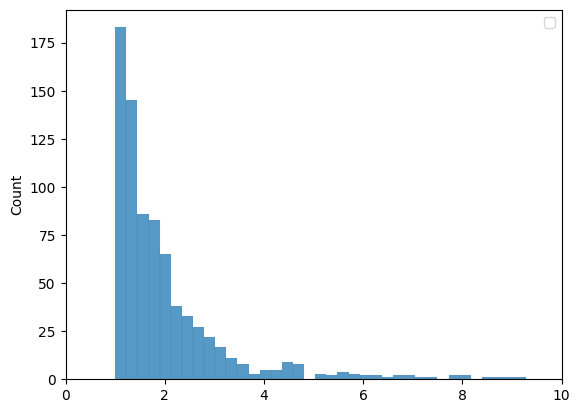

In [ ]:
sns.histplot(ratios_list_34)
plt.legend()
plt.xlim(0,10)
plt.show()


In [ ]:
vmodel23(batch_x)

tensor([[1.2389e-09, 1.8714e-09, 9.8336e-03,  ..., 9.7297e-05, 1.0161e-06,
         1.0163e-06],
        [2.7601e-02, 6.4493e-06, 2.4232e-12,  ..., 2.1514e-14, 1.5837e-08,
         9.7239e-01],
        [8.5898e-12, 3.4601e-11, 1.8313e-06,  ..., 1.4546e-05, 2.6765e-12,
         5.9253e-11],
        ...,
        [1.4887e-16, 1.7446e-17, 1.6962e-05,  ..., 2.0277e-07, 3.9048e-15,
         3.1410e-14],
        [7.5148e-04, 1.1867e-03, 5.1307e-03,  ..., 5.9588e-07, 2.1643e-08,
         7.1612e-07],
        [1.3233e-15, 9.8889e-16, 1.6892e-14,  ..., 1.0000e+00, 2.0792e-16,
         2.6871e-15]], device='cuda:1', grad_fn=<SoftmaxBackward0>)

In [ ]:
print('Train error', 1.0 - prediction_onepass.eq(y).float().mean().item())
print('Test error', 1.0 - prediction_onepass_te.eq(y_te).float().mean().item())

Train error 0.0706413984298706
Test error 0.2623000144958496


In [ ]:
def build_equivalence_class(model, starting_point, delta=1e-4):

    g = torch.eye(10)
    g = g.to(device)
    eq_class = []

    point = starting_point
    eq_class.append(point.cpu().detach().numpy())

    for i in range(1000):
        point = simec(model, point, g, 1, delta=delta)
        eq_class.append(point.cpu().detach().numpy())
        print(point)
        print(model(point))

    eq_class = np.array(eq_class)

    # for i in range(len(eq_class)):
    #     eq_class[i] = (max_values[:4]-min_values[:4])*eq_class[i]+min_values[:4]
    
    return eq_class

#--------------------------------------------------------------------------------------------

def plot_2d_projections(eq_class):

    plt.title("T-V")
    plt.scatter(eq_class[:,0], eq_class[:,1], color="red")
    plt.show()
    plt.clf()

    plt.title("T-AP")
    plt.scatter(eq_class[:,0], eq_class[:,2], color="red")
    plt.show()
    plt.clf()

    plt.title("T-RH")
    plt.scatter(eq_class[:,0], eq_class[:,3], color="red")
    plt.show()
    plt.clf()

    plt.title("V-RH")
    plt.scatter(eq_class[:,1], eq_class[:,3], color="red")
    plt.show()
    plt.clf()

#--------------------------------------------------------------------------------------------

def plot_3d_projection(eq_class):

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(eq_class[:,0], eq_class[:,1], eq_class[:,2])
    plt.show()
    plt.clf()


In [ ]:
x, y = next(iter(train_loader))
t = x[:1].requires_grad_(True).to(device)

In [ ]:
#Run Simexp
g = torch.eye(10).to(device)
x1 = t
imgs_list_simec = simec(vmodel23,  x1, g, 5000, save_every_n_steps = 100, delta = 0.1)

Step: 0
Peudolength of the curve: 0.0
Step: 100
Peudolength of the curve: tensor(4.8844e-08, device='cuda:1', dtype=torch.float64)
Step: 200
Peudolength of the curve: tensor(1.1490e-07, device='cuda:1', dtype=torch.float64)
Step: 300
Peudolength of the curve: tensor(1.7208e-07, device='cuda:1', dtype=torch.float64)
Step: 400
Peudolength of the curve: tensor(2.2284e-07, device='cuda:1', dtype=torch.float64)
Step: 500
Peudolength of the curve: tensor(2.8208e-07, device='cuda:1', dtype=torch.float64)
Step: 600
Peudolength of the curve: tensor(3.3707e-07, device='cuda:1', dtype=torch.float64)
Step: 700
Peudolength of the curve: tensor(3.7088e-07, device='cuda:1', dtype=torch.float64)
Step: 800
Peudolength of the curve: tensor(4.0761e-07, device='cuda:1', dtype=torch.float64)
Step: 900
Peudolength of the curve: tensor(4.4121e-07, device='cuda:1', dtype=torch.float64)
Step: 1000
Peudolength of the curve: tensor(4.6672e-07, device='cuda:1', dtype=torch.float64)
Step: 1100
Peudolength of the c

In [ ]:
#Run Simexp
imgs_list_simexp = simec_simexp(vmodel23,  x1, g, 5000, save_every_n_steps = 100, delta = 0.1, delta_simexp = 0.1)

Step: 0
Pseudolength of the curve: 0.0
Step: 100
Pseudolength of the curve: tensor(13.9490, device='cuda:1', dtype=torch.float64)
Step: 200
Pseudolength of the curve: tensor(13.9490, device='cuda:1', dtype=torch.float64)
Step: 300
Pseudolength of the curve: tensor(13.9490, device='cuda:1', dtype=torch.float64)
Step: 400
Pseudolength of the curve: tensor(28.3629, device='cuda:1', dtype=torch.float64)
Step: 500
Pseudolength of the curve: tensor(28.5242, device='cuda:1', dtype=torch.float64)
Step: 600
Pseudolength of the curve: tensor(28.5242, device='cuda:1', dtype=torch.float64)
Step: 700
Pseudolength of the curve: tensor(28.5242, device='cuda:1', dtype=torch.float64)
Step: 800
Pseudolength of the curve: tensor(28.5242, device='cuda:1', dtype=torch.float64)
Step: 900
Pseudolength of the curve: tensor(28.5242, device='cuda:1', dtype=torch.float64)
Step: 1000
Pseudolength of the curve: tensor(28.5242, device='cuda:1', dtype=torch.float64)
Step: 1100
Pseudolength of the curve: tensor(28.52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67133546..1.8592545].


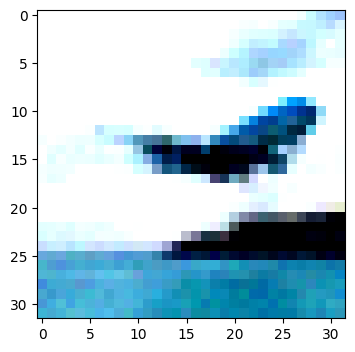

In [ ]:
visualize_sample(imgs_list_simec[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6660706..1.7988244].


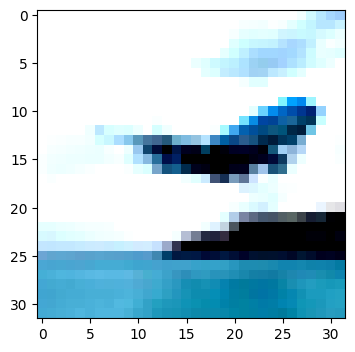

In [ ]:
visualize_sample(t.detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71455..1.87685].


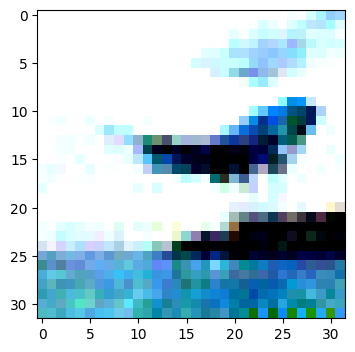

In [ ]:
visualize_sample(imgs_list_simexp[-1])

In [ ]:
len(imgs_list_simec)

50

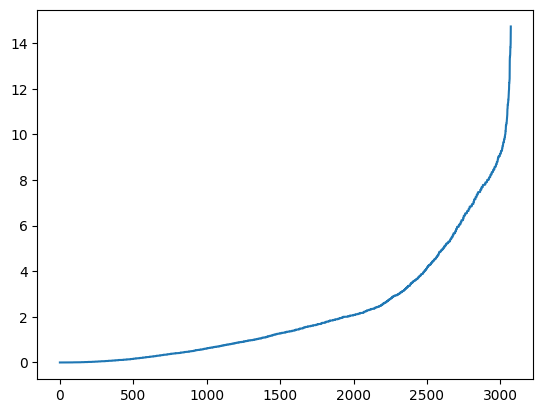

In [ ]:
plt.clf()
plt.plot((x[0]-x[1]).abs().pow(2).flatten().sort()[0])
plt.show()

In [ ]:
(x[0]-imgs_list_simexp[-1]).abs().pow(2).flatten().sum()

tensor(176.7786)

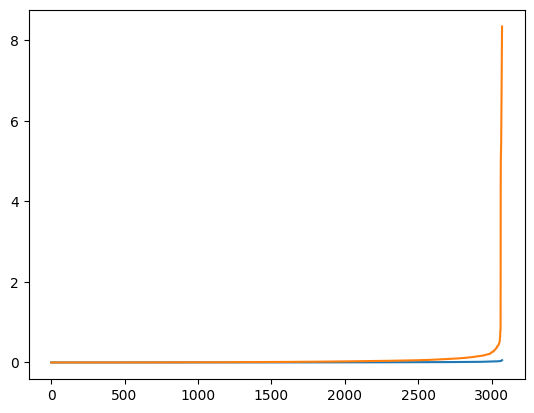

In [ ]:
plt.clf()
plt.plot((x[0]-imgs_list_simec[-1]).abs().pow(2).flatten().sort()[0])
plt.plot((x[0]-imgs_list_simexp[-1]).abs().pow(2).flatten().sort()[0])
plt.show()

In [ ]:
a = (x[0]-imgs_list_simexp[-1]).abs().pow(2).flatten().sort()
df = pd.DataFrame(a[0], index=list(a[1].numpy()), columns=['Difference'])

In [ ]:
df[df.Difference < 1e-8].sort_index()

,Difference
2104,2.788866e-09
2495,4.113247e-09


In [ ]:
b = (x[0]-imgs_list_simec[-1]).abs().pow(2).flatten().sort()
df2 = pd.DataFrame(b[0], index=list(b[1].numpy()), columns=['Difference'])

In [ ]:
df2[df2.Difference < 1e-8].sort_index()

,Difference
571,4.633321e-09
587,6.004086e-11
801,3.496098e-09
948,7.163692e-11
1489,5.436252e-09
1584,3.887081e-09


In [ ]:
(x[0]-imgs_list_simec[-1]).abs().pow(2).flatten().sort()

torch.return_types.sort(
values=tensor([6.0041e-11, 7.1637e-11, 3.4961e-09,  ..., 4.9925e-02, 5.4059e-02,
        5.7545e-02]),
indices=tensor([ 587,  948,  801,  ..., 1920,  480, 2722]))

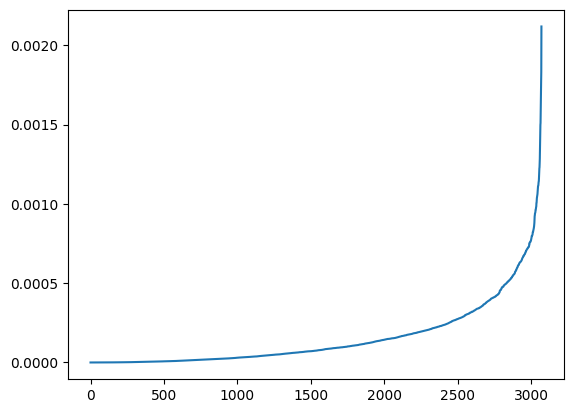

In [ ]:
plt.clf()
plt.plot((x[0]-imgs_list_simec[2]).abs().pow(2).flatten().sort()[0])
plt.show()

In [ ]:
vmodel23(imgs_list_simexp[-1].to(device))

tensor([[3.7452e-33, 1.3210e-40, 1.8239e-23, 4.9851e-37, 2.8589e-32, 3.1738e-34,
         1.8102e-37, 3.5229e-37, 7.4813e-32, 1.0000e+00]], device='cuda:1',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
vmodel23(t.to(device))

tensor([[6.2256e-05, 1.2488e-14, 3.7671e-10, 1.6849e-12, 7.2231e-14, 4.2815e-14,
         8.3182e-17, 2.3482e-18, 9.9994e-01, 1.8280e-13]], device='cuda:1',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
vmodel23(imgs_list_simec[-1].to(device))

tensor([[2.5471e-05, 2.5609e-15, 3.2886e-10, 8.2084e-13, 1.1946e-13, 4.4423e-14,
         8.3684e-17, 1.3018e-18, 9.9997e-01, 8.7926e-14]], device='cuda:1',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
pd.DataFrame((vmodel23.layers[0].cpu()(imgs_list_simec[-3].cpu())).flatten().detach().numpy()==0).value_counts()

0    
False    8436
True     4364
Name: count, dtype: int64

In [ ]:
pd.DataFrame(((vmodel23.layers[0].cpu()(t.cpu()).cpu()-vmodel23.layers[0].cpu()(imgs_list_simec[-3].cpu()).cpu())==0).flatten()).value_counts()

0    
False    8475
True     4325
Name: count, dtype: int64

In [ ]:
pd.DataFrame(((vmodel23.layers[0].cpu()(t.cpu()).cpu()-vmodel23.layers[0].cpu()(imgs_list_simexp[-1].cpu()).cpu())==0).flatten()).value_counts()

0    
False    8735
True     4065
Name: count, dtype: int64

In [ ]:
pd.DataFrame(((vmodel23.layers[0].cpu()(t.cpu()).cpu()-vmodel23.layers[0].cpu()(imgs_list_simec[-1].cpu()).cpu())==0).flatten()).value_counts()

0    
False    8474
True     4326
Name: count, dtype: int64

In [ ]:
pd.DataFrame(((vmodel23.layers[0].cpu()(t.cpu()).cpu()-vmodel23.layers[0].cpu()(imgs_list_simec[-1].cpu()).cpu())==0).flatten()).value_counts()

0    
False    8474
True     4326
Name: count, dtype: int64

In [ ]:
def create_bones(model):
    
    class bone(torch.nn.Module):

        def __init__(self, no_layers):
            super(bone, self).__init__()
            self.no_layers = no_layers
            #self.embedding = model.embedding
            self.layers = model.layers[:self.no_layers].to(device)
        
        def forward(self, x):
            x_ = x
            for layer in self.layers:
                layer.eval()
                with torch.no_grad():
                    x_ = layer(x_)
            return x_

    return [ bone(i+1).to(device) for i in range(len(model.layers))]

In [ ]:
def return_pairs(list):
    pairs = []
    for i in range(len(list)-1):
        pairs.append([list[i],list[i+1]])
    return pairs

In [ ]:
def layer_graph(model, list_points, graphs=1):
    vertices_info = {'vertices': torch.Tensor().to(device), 'W_vertices': []}
    edges_info = {'edges': [], 'W_edges': []}
    bones = create_bones(model)
    batch_x = list_points.to(device)
    #batch_y = batch_y.to(device)

    prediction = model(batch_x)
    prediction_bones = bones[0](batch_x)

    
    distances = (prediction_bones[:-1]-prediction_bones[1:]).pow(2).sum((1,2,3)).sqrt()
#torch.nn.functional.softmax(torch.Tensor(torch.max(distances)-distances))
    vertices_info['vertices'] = torch.cat((vertices_info['vertices'], prediction_bones), dim=0)
    correct_prob = []
    for j, item in enumerate(range(len(list_points))):
        correct_prob.append(prediction[8][-1].detach().item())
    vertices_info['W_vertices'] += correct_prob
    if len(edges_info['edges'])==0:
        edges_info['edges'] += return_pairs(prediction_bones)
        edges_info['W_edges'] += torch.Tensor(distances)
        last_item_batch = prediction_bones[-1].reshape(1,prediction_bones.size(1),prediction_bones.size(2),prediction_bones.size(3))
    else:
        first_item_batch = prediction_bones[0].reshape(1,prediction_bones.size(1),prediction_bones.size(2),prediction_bones.size(3))
        distance_left = (first_item_batch-last_item_batch).pow(2).sum((1,2,3)).sqrt()
        edges_info['W_edges'] += torch.Tensor(distance_left)
        edges_info['W_edges'] += torch.Tensor(distances)
        edges_info['edges'] += return_pairs(torch.cat((vertices_info['vertices'][-1:], prediction_bones),dim=0))
    print(edges_info['W_edges'])
    edges_info['W_edges'] = torch.Tensor(edges_info['W_edges']).squeeze()
    #edges_info['W_edges'] = torch.nn.functional.softmax(torch.Tensor(torch.max(edges_info['W_edges'])-edges_info['W_edges']))
    edges_info['W_edges'] =torch.Tensor(1+(torch.max(edges_info['W_edges'])-edges_info['W_edges'])/(torch.max(edges_info['W_edges'])-torch.min(edges_info['W_edges'])))
    return vertices_info, edges_info

In [ ]:
class_points = torch.Tensor([item.detach().numpy() for item in imgs_list_simec]).squeeze(1)
a, b = layer_graph(vmodel23, class_points)

[tensor(1.9717, device='cuda:1'), tensor(1.9894, device='cuda:1'), tensor(1.9673, device='cuda:1'), tensor(2.0006, device='cuda:1'), tensor(2.0744, device='cuda:1'), tensor(2.0150, device='cuda:1'), tensor(2.0635, device='cuda:1'), tensor(2.0288, device='cuda:1'), tensor(2.1100, device='cuda:1'), tensor(2.0614, device='cuda:1'), tensor(2.0741, device='cuda:1'), tensor(2.0442, device='cuda:1'), tensor(2.0194, device='cuda:1'), tensor(2.0667, device='cuda:1'), tensor(2.0115, device='cuda:1'), tensor(2.0422, device='cuda:1'), tensor(2.0834, device='cuda:1'), tensor(2.0112, device='cuda:1'), tensor(2.1127, device='cuda:1'), tensor(2.0567, device='cuda:1'), tensor(2.0513, device='cuda:1'), tensor(2.0690, device='cuda:1'), tensor(1.9630, device='cuda:1'), tensor(2.0837, device='cuda:1'), tensor(2.0301, device='cuda:1'), tensor(2.0260, device='cuda:1'), tensor(1.9669, device='cuda:1'), tensor(2.0662, device='cuda:1'), tensor(2.0960, device='cuda:1'), tensor(2.0808, device='cuda:1'), tensor(2.

In [ ]:
# def layer_graph(model, loader, graphs=1):
#     vertices_info = {'vertices': torch.Tensor().to(device), 'W_vertices': []}
#     edges_info = {'edges': [], 'W_edges': []}
#     bones = create_bones(model)
#     for i, (batch_x, batch_y) in enumerate(loader):
#         batch_x = batch_x.to(device)
#         batch_y = batch_y.to(device)

#         prediction = model(batch_x)
#         prediction_bones = bones[0](batch_x)

        
#         distances = (prediction_bones[:-1]-prediction_bones[1:]).pow(2).sum((1,2,3)).sqrt()
# #torch.nn.functional.softmax(torch.Tensor(torch.max(distances)-distances))

#         vertices_info['vertices'] = torch.cat((vertices_info['vertices'], prediction_bones), dim=0)
#         correct_prob = []
#         for j, item in enumerate(batch_y):
#             correct_prob.append(prediction[j][item].detach().item())
#         vertices_info['W_vertices'] += correct_prob
#         if len(edges_info['edges'])==0:
#             edges_info['edges'] += return_pairs(prediction_bones)
#             edges_info['W_edges'] += torch.Tensor(distances)
#             print(prediction_bones[-1, :, :, :].shape)
#             last_item_batch = prediction_bones[-1].reshape(1,prediction_bones.size(1),prediction_bones.size(2),prediction_bones.size(3))
#         else:
#             first_item_bartch = prediction_bones[0].reshape(1,prediction_bones.size(1),prediction_bones.size(2),prediction_bones.size(3))
#             distance_left = (first_item_bartch-last_item_batch).pow(2).sum((1,2,3)).sqrt()
#             edges_info['W_edges'] += torch.Tensor(distance_left)
#             edges_info['W_edges'] += torch.Tensor(distances)
#             edges_info['edges'] += return_pairs(torch.cat((vertices_info['vertices'][-1:], prediction_bones),dim=0))

#         print(i)
#         if i == 0:
#             break
#     edges_info['W_edges'] = torch.Tensor(edges_info['W_edges']).squeeze()
#     print(edges_info['W_edges'])
#     #edges_info['W_edges'] = torch.nn.functional.softmax(torch.Tensor(torch.max(edges_info['W_edges'])-edges_info['W_edges']))
#     edges_info['W_edges'] =torch.Tensor((torch.max(edges_info['W_edges'])-edges_info['W_edges'])/(torch.max(edges_info['W_edges'])-torch.min(edges_info['W_edges'])))
#     return vertices_info, edges_info

In [ ]:
len(a['vertices'])

10

In [ ]:
len(a['W_vertices'])

10

In [ ]:
len(b['edges'])

9

In [ ]:
b['W_edges'][1]

tensor(0.6719)

In [ ]:
def Forman_Ricci_Curvature(vertices_info, edges_info, edge=0):
    if edge == 0:
        FMC = edges_info['W_edges'][edge]*( (vertices_info['W_vertices'][edge]/edges_info['W_edges'][edge]) + (vertices_info['W_vertices'][edge+1]/edges_info['W_edges'][edge]) - (vertices_info['W_vertices'][edge+1]/torch.sqrt(edges_info['W_edges'][edge]*edges_info['W_edges'][edge+1])))
    elif edge == len(edges_info['edges'])-1:
        FMC = edges_info['W_edges'][edge]*( (vertices_info['W_vertices'][edge]/edges_info['W_edges'][edge]) + (vertices_info['W_vertices'][edge+1]/edges_info['W_edges'][edge]) - (vertices_info['W_vertices'][edge]/torch.sqrt(edges_info['W_edges'][edge-1]*edges_info['W_edges'][edge])))
    else:
        FMC = edges_info['W_edges'][edge]*( (vertices_info['W_vertices'][edge]/edges_info['W_edges'][edge]) + (vertices_info['W_vertices'][edge+1]/edges_info['W_edges'][edge]) 
                                     - (vertices_info['W_vertices'][edge+1]/torch.sqrt(edges_info['W_edges'][edge]*edges_info['W_edges'][edge+1]))
                                     - (vertices_info['W_vertices'][edge]/torch.sqrt(edges_info['W_edges'][edge-1]*edges_info['W_edges'][edge])) )
    return FMC

In [ ]:
class_points = torch.Tensor([item.detach().numpy() for item in imgs_list_simexp]).squeeze(1)
vertices_info, edges_info = layer_graph(vmodel23, class_points)
curvatures = [ Forman_Ricci_Curvature(vertices_info, edges_info, edge=i) for i in range(49) ]

[tensor(7.0404, device='cuda:1'), tensor(4.8744, device='cuda:1'), tensor(5.0451, device='cuda:1'), tensor(5.8393, device='cuda:1'), tensor(5.6807, device='cuda:1'), tensor(4.6210, device='cuda:1'), tensor(4.8854, device='cuda:1'), tensor(5.3551, device='cuda:1'), tensor(8.3681, device='cuda:1'), tensor(6.8383, device='cuda:1'), tensor(5.0249, device='cuda:1'), tensor(4.5668, device='cuda:1'), tensor(3.9742, device='cuda:1'), tensor(4.3710, device='cuda:1'), tensor(3.7150, device='cuda:1'), tensor(4.5462, device='cuda:1'), tensor(5.9737, device='cuda:1'), tensor(5.6512, device='cuda:1'), tensor(4.9802, device='cuda:1'), tensor(3.4694, device='cuda:1'), tensor(4.3704, device='cuda:1'), tensor(5.3581, device='cuda:1'), tensor(3.6846, device='cuda:1'), tensor(4.4302, device='cuda:1'), tensor(3.9196, device='cuda:1'), tensor(5.1197, device='cuda:1'), tensor(3.6774, device='cuda:1'), tensor(2.9779, device='cuda:1'), tensor(2.7346, device='cuda:1'), tensor(3.2028, device='cuda:1'), tensor(3.

In [ ]:
vmodel23(imgs_list_simexp[0].to(device))

tensor([[6.2352e-05, 1.2709e-14, 3.8585e-10, 1.6576e-12, 7.0763e-14, 4.1980e-14,
         8.3020e-17, 2.3522e-18, 9.9994e-01, 1.8151e-13]], device='cuda:1',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
edges_info['W_edges']

tensor([1.2148, 1.5652, 1.5376, 1.4091, 1.4348, 1.6062, 1.5634, 1.4874, 1.0000,
        1.2475, 1.5409, 1.6150, 1.7108, 1.6467, 1.7528, 1.6183, 1.3874, 1.4395,
        1.5481, 1.7925, 1.6468, 1.4870, 1.7577, 1.6371, 1.7197, 1.5255, 1.7589,
        1.8720, 1.9114, 1.8356, 1.8315, 1.6095, 1.6442, 1.7741, 1.8067, 1.7074,
        1.4985, 1.4961, 1.2908, 1.6457, 1.6090, 1.6037, 1.8367, 1.7861, 1.9971,
        1.9909, 1.9505, 2.0000, 1.8186])

In [ ]:
vertices_info['W_vertices'][5:10]

[1.2984210400108533e-14,
 1.2984210400108533e-14,
 1.2984210400108533e-14,
 1.2984210400108533e-14,
 1.2984210400108533e-14]

In [ ]:
curvatures

[tensor(1.4530e-14),
 tensor(-1.8702e-15),
 tensor(-4.6406e-16),
 tensor(6.7099e-16),
 tensor(5.9473e-16),
 tensor(-9.3019e-16),
 tensor(-1.5351e-16),
 tensor(-2.5319e-15),
 tensor(3.6971e-15),
 tensor(-2.1671e-16),
 tensor(-1.1448e-15),
 tensor(6.0426e-17),
 tensor(-6.3043e-16),
 tensor(6.4506e-16),
 tensor(-9.4051e-16),
 tensor(-5.3117e-16),
 tensor(1.1996e-15),
 tensor(2.2163e-16),
 tensor(4.3697e-16),
 tensor(-1.5499e-15),
 tensor(-1.4073e-16),
 tensor(1.6878e-15),
 tensor(-1.6025e-15),
 tensor(7.6912e-16),
 tensor(-1.1251e-15),
 tensor(1.6468e-15),
 tensor(-5.5910e-16),
 tensor(-2.7681e-16),
 tensor(-4.0097e-16),
 tensor(2.4533e-16),
 tensor(-8.5200e-16),
 tensor(9.4979e-16),
 tensor(3.4559e-16),
 tensor(-3.8579e-16),
 tensor(-4.9062e-16),
 tensor(-5.1416e-16),
 tensor(8.1021e-16),
 tensor(-9.8413e-16),
 tensor(2.4086e-15),
 tensor(-1.8237e-15),
 tensor(1.2406e-16),
 tensor(8.7260e-16),
 tensor(-1.0937e-15),
 tensor(8.8528e-16),
 tensor(-7.6583e-16),
 tensor(-1.1338e-16),
 tensor(

In [ ]:
class_points = torch.Tensor([item.detach().numpy() for item in imgs_list_simec]).squeeze(1)
vertices_info, edges_info = layer_graph(vmodel, class_points)
[ Forman_Ricci_Curvature(vertices_info, edges_info, edge=i) for i in range(49) ]

[tensor(1.9717, device='cuda:1'), tensor(1.9894, device='cuda:1'), tensor(1.9673, device='cuda:1'), tensor(2.0006, device='cuda:1'), tensor(2.0744, device='cuda:1'), tensor(2.0150, device='cuda:1'), tensor(2.0635, device='cuda:1'), tensor(2.0288, device='cuda:1'), tensor(2.1100, device='cuda:1'), tensor(2.0614, device='cuda:1'), tensor(2.0741, device='cuda:1'), tensor(2.0442, device='cuda:1'), tensor(2.0194, device='cuda:1'), tensor(2.0667, device='cuda:1'), tensor(2.0115, device='cuda:1'), tensor(2.0422, device='cuda:1'), tensor(2.0834, device='cuda:1'), tensor(2.0112, device='cuda:1'), tensor(2.1127, device='cuda:1'), tensor(2.0567, device='cuda:1'), tensor(2.0513, device='cuda:1'), tensor(2.0690, device='cuda:1'), tensor(1.9630, device='cuda:1'), tensor(2.0837, device='cuda:1'), tensor(2.0301, device='cuda:1'), tensor(2.0260, device='cuda:1'), tensor(1.9669, device='cuda:1'), tensor(2.0662, device='cuda:1'), tensor(2.0960, device='cuda:1'), tensor(2.0808, device='cuda:1'), tensor(2.

[tensor(1.1858e-13),
 tensor(6.7810e-15),
 tensor(-9.8487e-15),
 tensor(-1.0673e-14),
 tensor(2.6455e-14),
 tensor(-2.3902e-14),
 tensor(1.6909e-14),
 tensor(-2.8246e-14),
 tensor(2.9128e-14),
 tensor(-1.5673e-14),
 tensor(9.4003e-15),
 tensor(-1.9380e-15),
 tensor(-1.5587e-14),
 tensor(2.0620e-14),
 tensor(-1.8396e-14),
 tensor(-3.7463e-15),
 tensor(2.3615e-14),
 tensor(-4.2137e-14),
 tensor(3.4213e-14),
 tensor(-1.3493e-14),
 tensor(-5.2388e-15),
 tensor(2.2904e-14),
 tensor(-4.9245e-14),
 tensor(3.3271e-14),
 tensor(-1.1688e-14),
 tensor(9.4677e-15),
 tensor(-3.2243e-14),
 tensor(1.0426e-14),
 tensor(1.0787e-14),
 tensor(1.1745e-16),
 tensor(-5.2952e-16),
 tensor(-1.6887e-14),
 tensor(-2.8092e-15),
 tensor(2.8469e-14),
 tensor(3.2289e-15),
 tensor(-2.6642e-14),
 tensor(-2.0345e-14),
 tensor(2.6814e-14),
 tensor(3.9226e-15),
 tensor(-2.5058e-14),
 tensor(6.2811e-15),
 tensor(8.3819e-15),
 tensor(-1.3253e-15),
 tensor(-5.9404e-15),
 tensor(6.0238e-17),
 tensor(2.1538e-17),
 tensor(6.3

In [ ]:
starting_point = t
eq_class = build_equivalence_class(vmodel, starting_point, 1e-4)

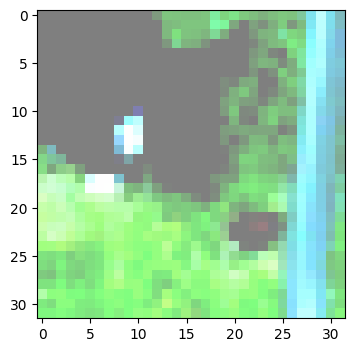

In [ ]:
visualize_sample(torch.Tensor(eq_class[-1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.6915178].


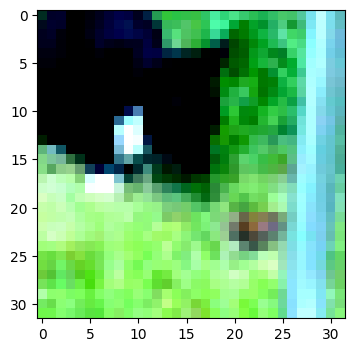

In [ ]:
visualize_sample(t.detach())